In [11]:
%load_ext autoreload
%autoreload 2

import sys; sys.path.append('.')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import pyro
from pyro import distributions as dist
from sklearn import metrics as sk_mtr
import torch
from torch.distributions import constraints

from src.nb import dataset
from src.nb import utils

pyro.enable_validation(True)

## Load dataset (Iris)

In [4]:
iris_dataset = dataset.load_iris_dataset()

Full (150, 4) (150,)
Train (120, 4) (120,)
Test (30, 4) (30,)


## Naive Bayes

![](https://jcaip.github.io/images/medimg/nbayes.png)

$$\mathbb{P}(c_k | x_1, x_2, \ldots, x_n) \propto \mathbb{P}(c_k, x_1, x_2, \ldots, x_n) = \mathbb{P}(c_k) \prod_{i=1}^{n}\mathbb{P}(x_i | c_k)$$

$$\hat{y} = \operatorname*{argmax}_{k \in \{1, 2, \ldots, K\}} \mathbb{P}(c_k | x_1, x_2, \ldots, x_n)$$

In [5]:
class GaussianNBClassifier:
    def __init__(self, num_epochs=500, lr=1e-2, verbose=False):
        self._num_epochs = num_epochs
        self._lr = lr
        self._verbose = verbose
        
        self._num_cls = None
        
        self._c_logits = None        
        self._num_probs = None
        
    def fit(self, X, y):        
        history = utils.train_svi(
            model=self._model,
            guide=self._guide,
            X=X, 
            y=y,
            num_epochs=self._num_epochs,
            lr=self._lr,
        )
        if self._verbose:
            utils.visualize_nb_parameters(history)
        else:
            return history
    
    def predict(self, X):
        pred = pyro.infer.Predictive(
            model=self._model,
            guide=self._guide,
            num_samples=1,
            return_sites=('logP(c|x)',),
        )
        log_pcx = pred(X)['logP(c|x)'].detach().squeeze(0).squeeze(0)
        y_pred = torch.argmax(log_pcx, dim=-1)
        return y_pred
    
    def _model(self, X, y=None):    
        if y is not None:  # training mode
            self._num_cls = max(y) + 1
            numerical_cols = X.columns.values
                    
            self._init_c_logits()
            self._init_num_params(X, numerical_cols)
            self._observe_numerical_features_given_classes(X, y)

        self._observe_classes(X, y)
        
    def _guide(self, X, y=None):
        pass
    
    def _init_c_logits(self):
        self._c_logits = pyro.param(
            'c_logits',
            torch.ones(self._num_cls).div(self._num_cls),
            constraint=constraints.simplex
        )
        
    def _init_num_params(self, X, numerical_cols):
        self._num_probs = {
            col: {
                'mu': pyro.param(f'{col}_mu', torch.zeros(self._num_cls)),
                'sigma': pyro.param(f'{col}_sigma', torch.ones(self._num_cls)),
            }
            for col in numerical_cols
        }
        
    def _observe_numerical_features_given_classes(self, X, y):
        for c in range(self._num_cls):
            x_c = X[y==c]
            with pyro.plate(f'data-numerical-{c}', x_c.shape[0]):
                for nc, v in self._num_probs.items():
                    pyro.sample(
                        f'P(x_{nc}|c={c})', 
                        dist.Normal(v['mu'][c], v['sigma'][c]),
                        obs=torch.tensor(x_c[nc].values),
                    )
                    
    def _get_log_likelihood(self, X):
        log_lk = []
        
        for c in range(self._num_cls):
            lps = []
            
            lps.extend([
                dist.Normal(v['mu'][c], v['sigma'][c]).log_prob(torch.tensor(X[nc].values))
                for nc, v in self._num_probs.items()
            ])

            log_lk.append(torch.stack(lps).sum(dim=0))
            
        return torch.stack(log_lk).t()
    
    def _observe_classes(self, X, y):
        if y is not None:
            y = torch.tensor(y)
        
        log_lk = self._get_log_likelihood(X)

        log_pcx = pyro.deterministic('logP(c|x)', self._c_logits.log() + log_lk)
        
        with pyro.plate('data-pred', X.shape[0]):    
            pyro.sample(
                'c',
                dist.Categorical(logits=log_pcx),
                obs=y,
            )

Loss = 4423.188970578416
Loss = 2204.916510524413
Loss = 1523.9664600239307
Loss = 1252.929331236918
Loss = 1067.168986522483
Loss = 942.7198101878424
Loss = 840.5294785907723
Loss = 754.3498642230817
Loss = 685.0919519272495
Loss = 621.4898646936857



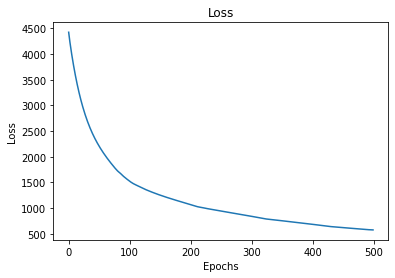

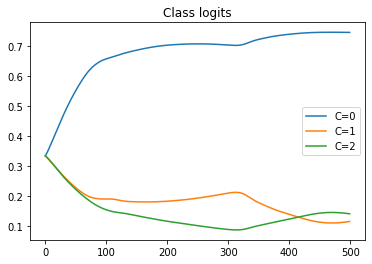

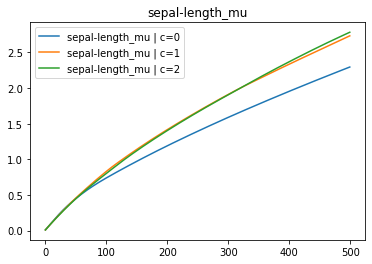

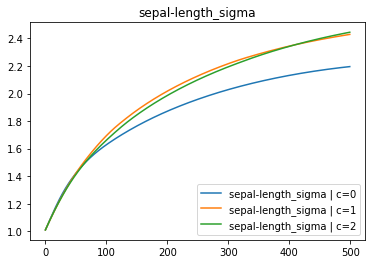

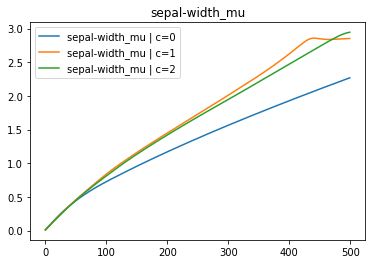

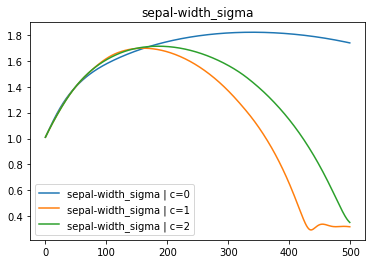

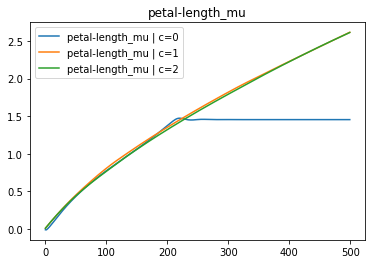

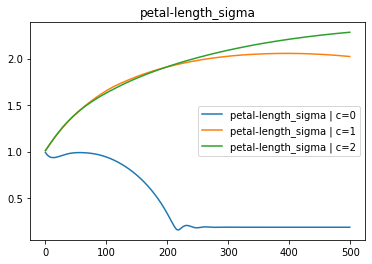

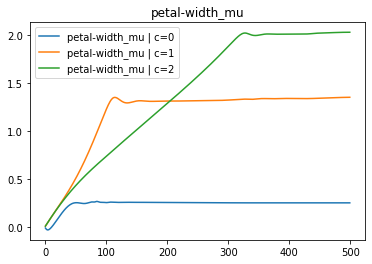

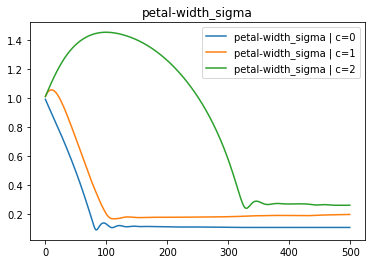

In [6]:
clf = GaussianNBClassifier(
    num_epochs=500,
    verbose=True,
)
clf.fit(X=iris_dataset['train']['X'], y=iris_dataset['train']['y'])

In [7]:
for tt in ('train', 'test'):
    print(tt)
    print(sk_mtr.classification_report(
        y_true=iris_dataset[tt]['y'],
        y_pred=clf.predict(X=iris_dataset[tt]['X']),
    ))

train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       0.93      0.95      0.94        40
           2       0.95      0.93      0.94        40

    accuracy                           0.96       120
   macro avg       0.96      0.96      0.96       120
weighted avg       0.96      0.96      0.96       120

test
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.91      1.00      0.95        10
           2       1.00      0.90      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



## Homework (part 1)
Extend the `GaussianNBClassifier` class so it can handle categorical features. Re-use as much code as possible.
Automatically identify categorical columns from dataset.

### Load dataset (CMC)

In [8]:
cmc_dataset = dataset.load_cmc(N=200)

Full (200, 9) (200,)
Train (160, 9) (160,)
Test (40, 9) (40,)


In [9]:
cmc_dataset['train']['X'].head()

,age,w-education,h-education,num-children,w-religion,w-working,h-occupation,sol-index,media-exposure
0,44,3,3,4,0,1,1,2,0
1,41,0,2,3,1,0,1,3,0
2,23,3,2,3,1,1,2,2,0
3,41,3,3,7,1,1,1,3,0
4,48,2,3,8,1,0,0,3,0


In [10]:
cmc_dataset['train']['y']

array([2, 0, 1, 1, 2, 0, 2, 2, 1, 0, 2, 2, 2, 2, 2, 0, 1, 1, 0, 2, 2, 1,
       1, 1, 2, 1, 0, 2, 2, 0, 2, 2, 2, 2, 1, 2, 0, 2, 0, 2, 2, 2, 2, 2,
       2, 2, 2, 0, 2, 0, 2, 0, 1, 2, 1, 0, 2, 2, 2, 1, 2, 2, 1, 0, 1, 2,
       0, 1, 2, 2, 2, 2, 0, 0, 0, 0, 2, 0, 1, 0, 2, 2, 0, 0, 2, 2, 2, 2,
       2, 0, 0, 2, 1, 0, 0, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 0,
       2, 0, 0, 0, 1, 2, 1, 0, 2, 2, 0, 1, 2, 0, 2, 1, 2, 0, 2, 2, 1, 0,
       0, 1, 0, 1, 2, 2, 2, 2, 0, 0, 2, 1, 1, 0, 2, 2, 1, 2, 1, 2, 1, 2,
       2, 2, 2, 2, 0, 2])

In [11]:
cmc_dataset['train']['X'].select_dtypes(exclude=['category'])

,age,num-children
0,44,4
1,41,3
2,23,3
3,41,7
4,48,8
...,...,...
155,29,4
156,21,2
157,46,6
158,26,3


Loss = 3400.7807216644287
Loss = 1999.506823837757
Loss = 1969.3264712691307
Loss = 1949.5393116623163
Loss = 1940.423069551587
Loss = 1937.1637715622783

{'c_logits': tensor([0.2830, 0.1677, 0.5494], grad_fn=<DivBackward0>), 'num-children_mu': tensor([2.4038, 3.6661, 3.4649], requires_grad=True), 'num-children_sigma': tensor([2.6528, 1.7283, 2.2412], grad_fn=<AddBackward0>), 'age_mu': tensor([32.8340, 34.4342, 30.5446], requires_grad=True), 'age_sigma': tensor([9.9349, 6.5667, 7.8453], grad_fn=<AddBackward0>), 'w-education_prob': tensor([[0.1336, 0.3971, 0.2065, 0.2628],
        [0.0028, 0.0768, 0.3417, 0.5787],
        [0.1134, 0.1999, 0.3176, 0.3691]], grad_fn=<DivBackward0>), 'h-education_prob': tensor([[0.0743, 0.1740, 0.2516, 0.5001],
        [0.0021, 0.0025, 0.2287, 0.7667],
        [0.0019, 0.1284, 0.2816, 0.5881]], grad_fn=<DivBackward0>), 'w-religion_prob': tensor([[0.0027, 0.9973],
        [0.2268, 0.7732],
        [0.1583, 0.8417]], grad_fn=<DivBackward0>), 'w-working_prob'

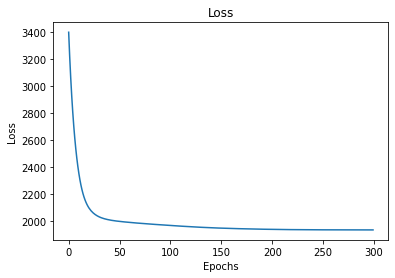

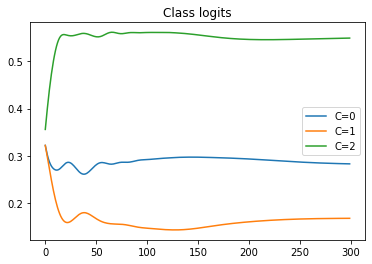

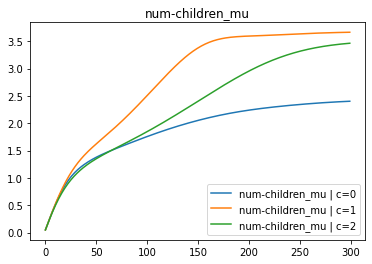

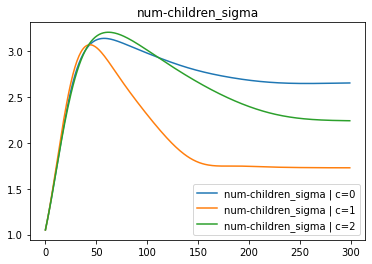

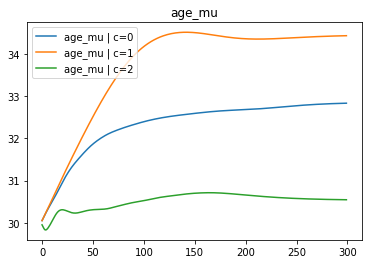

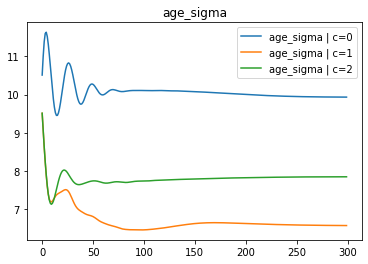

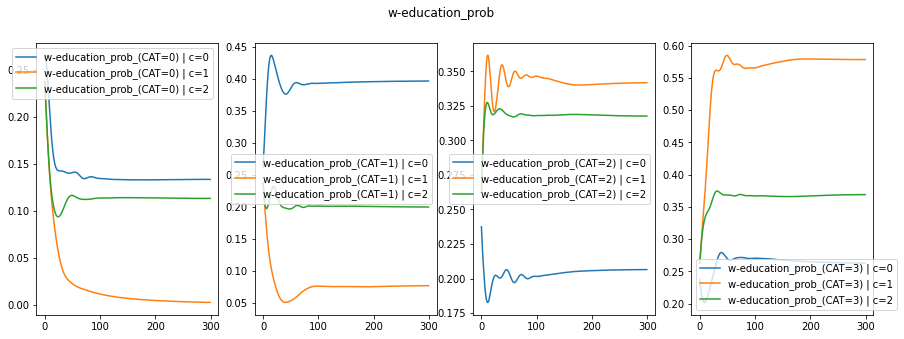

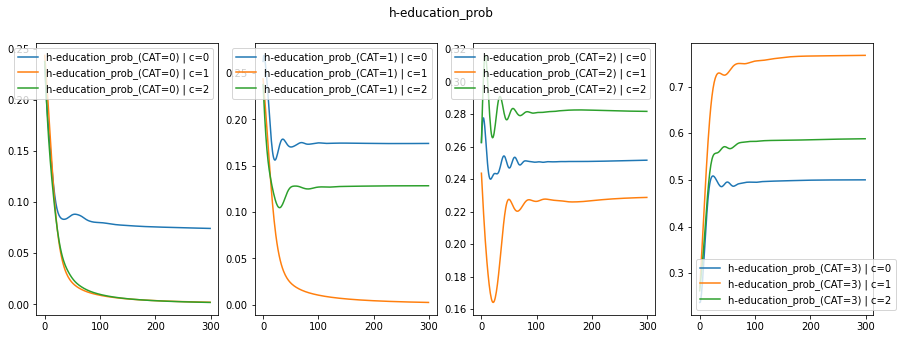

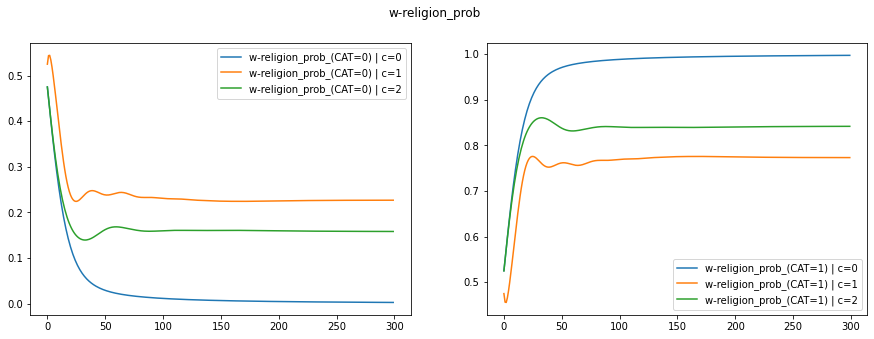

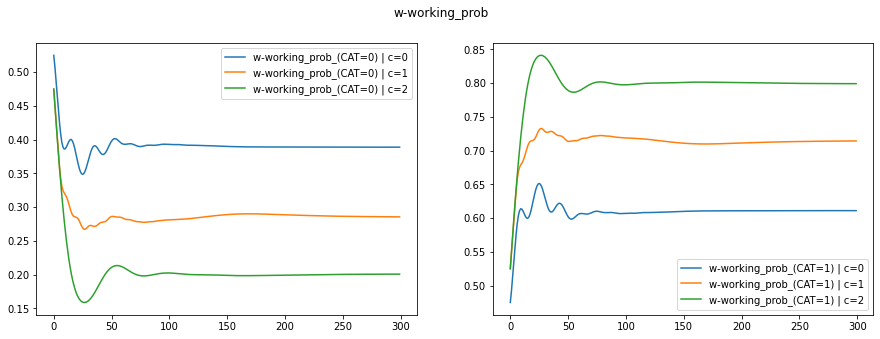

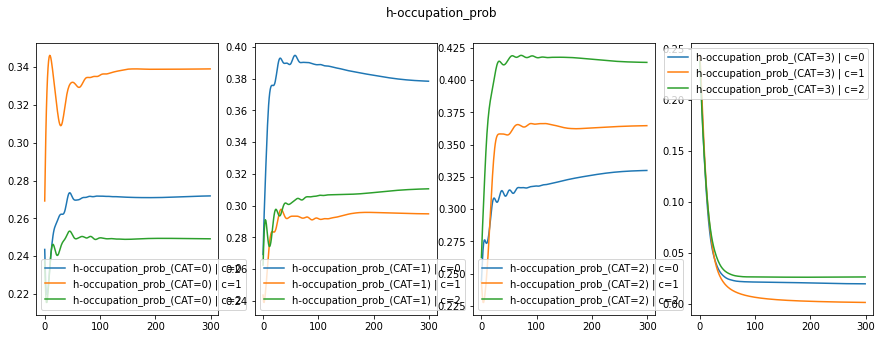

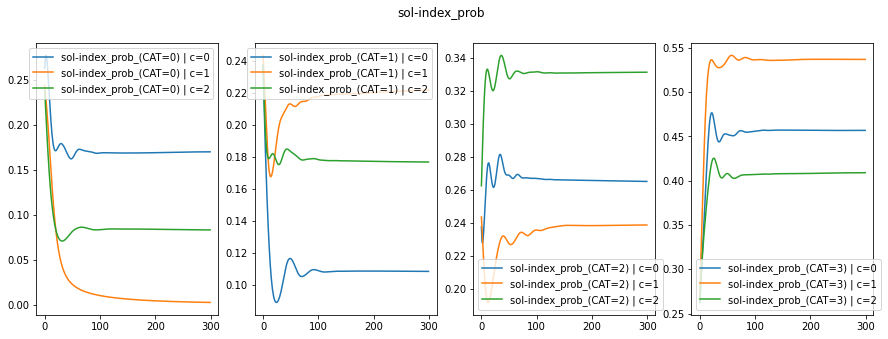

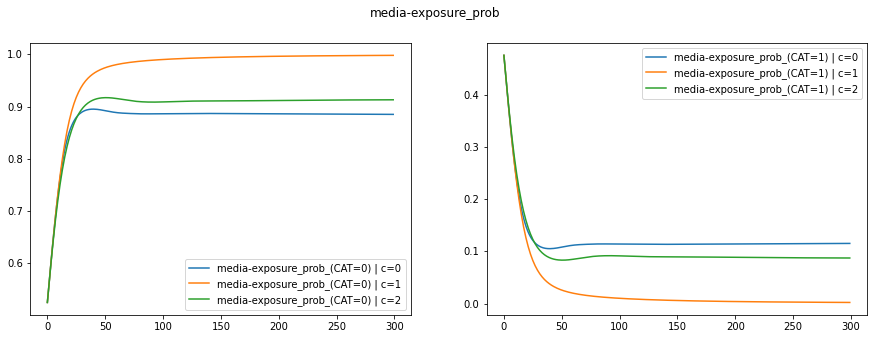

In [22]:
class FullNBClassifier(GaussianNBClassifier):
    def __init__(self, num_epochs=500, lr=1e-2, verbose=False):
        super().__init__(num_epochs,lr,verbose)
        self._cat_probs = None

    def _model(self, X, y=None):    
        if y is not None:  # training mode
            self._num_cls = max(y) + 1
            
            numerical_cols = X.select_dtypes(exclude=['category']).columns.values
            categorical_cols = X.select_dtypes(include=['category']).columns.values      
                    
            self._init_c_logits()
            self._init_num_params(X, numerical_cols)
            self._init_cat_params(X, categorical_cols)
            self._observe_numerical_features_given_classes(X, y)
            self._observe_categorical_features_given_classes(X, y)

        self._observe_classes(X, y)

    def _init_num_params(self, X, numerical_cols):
        self._num_probs = {
            col: {
                'mu': pyro.param(f'{col}_mu', torch.zeros(self._num_cls)),
                'sigma': pyro.param(
                    f'{col}_sigma',
                    torch.ones(self._num_cls),
                    constraint=constraints.positive
                ),
            }
            for col in numerical_cols[numerical_cols != 'age']
        }
            
        self._num_probs['age'] = {
             'mu': pyro.param('age_mu', torch.ones(self._num_cls) * 30),
             'sigma': pyro.param(
                 'age_sigma',
                 torch.ones(self._num_cls) * 10,
                 constraint=constraints.positive
             )
        }
        
    def _init_cat_params(self, X, categorical_cols):
        self._cat_probs = {
            col: pyro.param(
                    f'{col}_prob',
                    torch.ones((self._num_cls,max( X[col].astype(int) + 1)))
                         .div(max(X[col].astype(int) +1)),
                    constraint=constraints.simplex
                )
            for col in categorical_cols
        }

    def _observe_categorical_features_given_classes(self, X, y):
        for c in range(self._num_cls):
            x_c = X[y==c]
            with pyro.plate(f'data-categorical-{c}', x_c.shape[0]):
                for cc, v in self._cat_probs.items():
                    pyro.sample(
                        f'P(x_{cc}|c={c})', 
                        dist.Categorical(v[c]),
                        obs=torch.tensor(x_c[cc].values),
                    )
                    
    def _get_log_likelihood(self, X):
        log_lk = []
        
        for c in range(self._num_cls):
            lps = []
            
            lps.extend([
                dist.Normal(v['mu'][c], v['sigma'][c]).log_prob(torch.tensor(X[nc].values))
                for nc, v in self._num_probs.items()
            ])
            
            lps.extend([
                dist.Categorical(v[c]).log_prob(torch.tensor(X[cc].values))
                for cc, v in self._cat_probs.items()
            ])
            
            log_lk.append(torch.stack(lps).sum(dim=0))
            
        return torch.stack(log_lk).t()
            
clf = FullNBClassifier(
    num_epochs=300,
    lr=0.05,
    verbose=True,
)
clf.fit(X=cmc_dataset['train']['X'], y=cmc_dataset['train']['y'])

In [16]:
for tt in ('train', 'test'):
    print(tt)
    print(sk_mtr.classification_report(
        y_true=cmc_dataset[tt]['y'],
        y_pred=clf.predict(X=cmc_dataset[tt]['X']),
    ))

train
              precision    recall  f1-score   support

           0       0.70      0.50      0.58        42
           1       0.45      0.43      0.44        35
           2       0.62      0.72      0.67        83

    accuracy                           0.60       160
   macro avg       0.59      0.55      0.56       160
weighted avg       0.60      0.60      0.60       160

test
              precision    recall  f1-score   support

           0       0.43      0.27      0.33        11
           1       0.11      0.12      0.12         8
           2       0.54      0.62      0.58        21

    accuracy                           0.42        40
   macro avg       0.36      0.34      0.34        40
weighted avg       0.42      0.42      0.42        40

